,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,470218,25.2,1032524,55.2,621911,33.3
Vcells,870644,6.7,8388608,64.0,1601572,12.3


Loading required package: data.table
Loading required package: rpart
Loading required package: rpart.plot


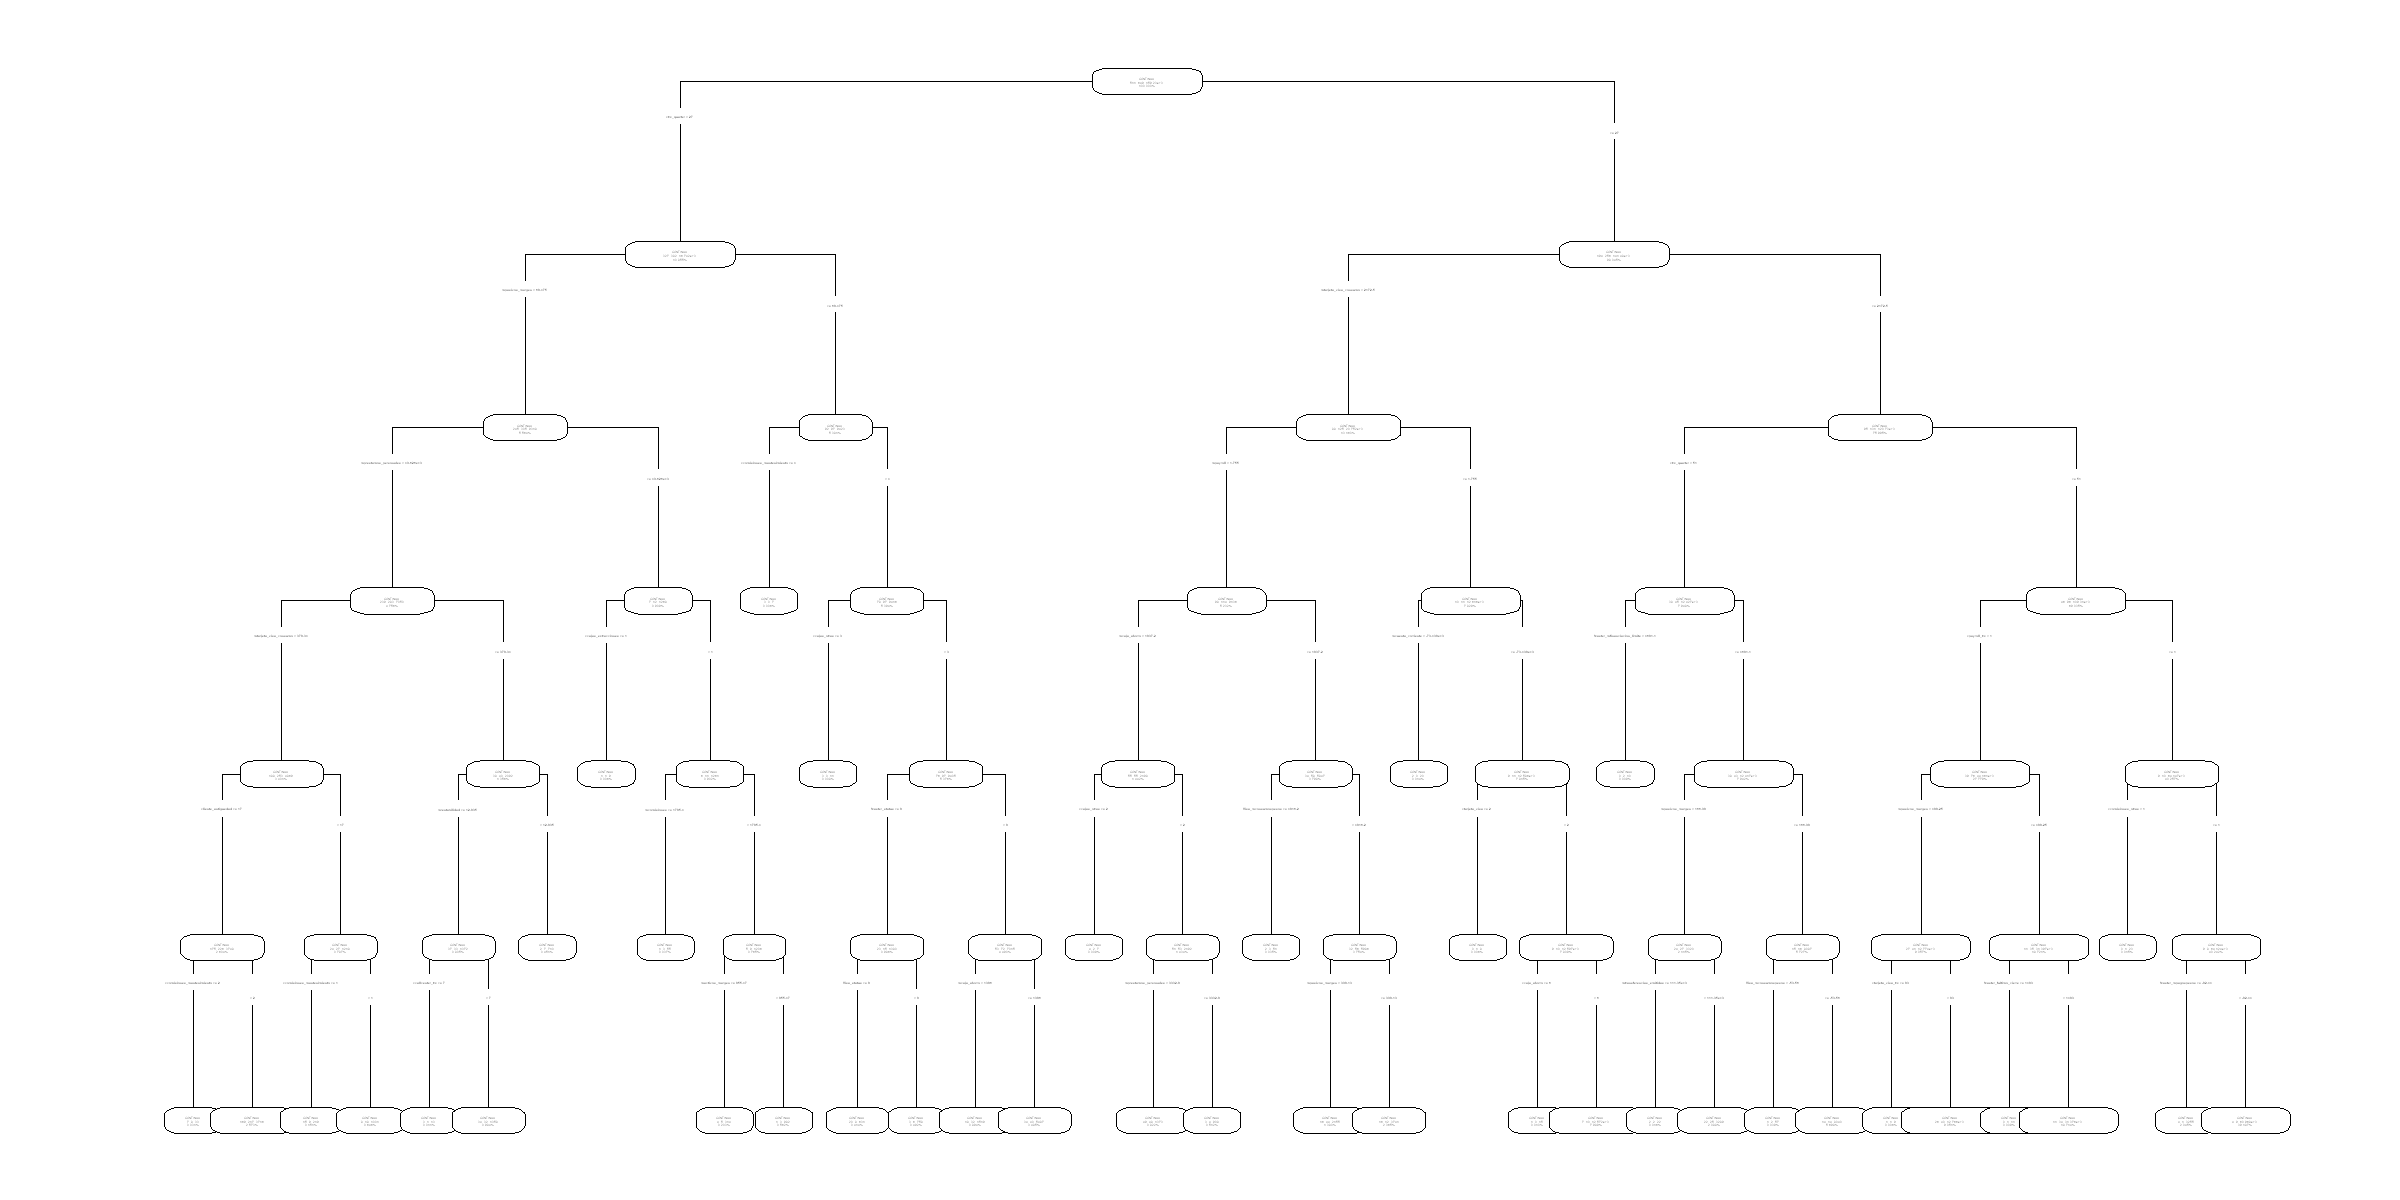

In [1]:
options(warn=-1)
options(repr.plot.width = 20, repr.plot.height = 10) 
rm( list=ls() )  #Borro todos los objetos
gc()   #Garbage Collection

#cargo las librerias que necesito
require("data.table")
require("rpart")
require("rpart.plot")

#Aqui debe cambiar los parametros por los que desea probar
cp = c(-0.5)
vmax_depth = c(6)
vmin_split = c(800)
vmin_bucket = c(10)

param_basicos  <- list( "cp"=          cp,  #complejidad minima
                        "minsplit"=   vmin_split,     #minima cantidad de registros en un nodo para hacer el split
                        "minbucket"=  vmin_bucket,     #minima cantidad de registros en una hoja
                        "maxdepth"=     vmax_depth )    #profundidad máxima del arbol



setwd("C:\\Users\\oliva\\OneDrive\\Desktop\\DS\\Austral\\08 - Labo1") #Aqui se debe poner la ruta de la PC local

#cargo los datos de 202011 que es donde voy a ENTRENAR el modelo
dtrain  <- fread("./labo/datasets/paquete_premium_202011.csv")

#genero el modelo,  aqui se construye el arbol
modelo  <- rpart("clase_ternaria ~ .",  #quiero predecir clase_ternaria a partir de el resto de las variables
                 data = dtrain,
                 xval=0,
                 control=  param_basicos )

#grafico el arbol
prp(modelo, extra=101, digits=5, branch=1, type=4, varlen=0, faclen=0)


#Ahora aplico al modelo  a los datos de 202101  y genero la salida para kaggle

#cargo los datos de 202011, que es donde voy a APLICAR el modelo
dapply  <- fread("./labo/datasets/paquete_premium_202101.csv")

#aplico el modelo a los datos nuevos
prediccion  <- predict( modelo, dapply , type = "prob")

#prediccion es una matriz con TRES columnas, llamadas "BAJA+1", "BAJA+2"  y "CONTINUA"
#cada columna es el vector de probabilidades 

#agrego a dapply una columna nueva que es la probabilidad de BAJA+2
dapply[ , prob_baja2 := prediccion[, "BAJA+2"] ]

#solo le envio estimulo a los registros con probabilidad de BAJA+2 mayor  a  1/60
dapply[ , Predicted  := as.numeric(prob_baja2 > 1/60) ]

#genero un dataset con las dos columnas que me interesan
entrega  <- dapply[   , list(numero_de_cliente, Predicted) ] #genero la salida

#genero el archivo para Kaggle
#creo la carpeta donde va el experimento
dir.create( "./labo/exp/", showWarnings = FALSE  )
dir.create( "./labo/exp/KA2022/", showWarnings = FALSE  )

fwrite( entrega, 
        file= "./labo/exp/KA2022/K242_002.csv", 
        sep= "," )